<a href="https://colab.research.google.com/github/KoMurase/FNC/blob/master/FNC_modeling_lgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/microsoft/LightGBM
!cd LightGBM && mkdir build && cd build && cmake .. && make -j"$(nproc)"
!cd LightGBM/python-package && python setup.py install --precompile

Cloning into 'LightGBM'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 19269 (delta 43), reused 20 (delta 11), pack-reused 19190
Receiving objects: 100% (19269/19269), 15.45 MiB | 31.21 MiB/s, done.
Resolving deltas: 100% (14049/14049), done.
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found

In [2]:
path = "/content/drive/My Drive/FNC/dataset/fake news detection(FakeNewsNet)"

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

import gc 

import lightgbm as lgb
from sklearn import metrics

from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
train = pd.read_csv(path + "/fnn_train.csv", usecols={"fullText_based_content", "label_fnn"})
val = pd.read_csv(path + "/fnn_dev.csv", usecols={"fullText_based_content", "label_fnn"})

In [7]:
def flg(label):
  if label=="fake":
    return 0
  else:
    return 1
    
train['flg'] = train['label_fnn'].apply(flg)
val['flg'] = val['label_fnn'].apply(flg)

前処理をどうするか？？？

In [8]:
import re
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def cleaning(texts):
    clean_texts = []
    for text in texts:
        #アルファベット以外をスペースに置き換え
        clean_punc = re.sub(r'[^a-zA-Z]', ' ', text)
        #単語長が3文字以下のものは削除する
        #clean_short_tokenized = [word for word in clean_punc.split() if len(word) > 3]
        #ステミング
        #clean_normalize = [stemmer.stem(word) for word in clean_short_tokenized]
        
        #単語同士をスペースでつなぎ, 文章に戻す
        #clean_text = ' '.join(clean_normalize)
        clean_text = ''.join(clean_punc)
        clean_texts.append(clean_text)
    return clean_texts

train["full_text"] = cleaning(train["fullText_based_content"] )
val["full_text"] = cleaning(val["fullText_based_content"])

train = train.drop('fullText_based_content',axis=1)
val = val.drop('fullText_based_content',axis=1)

In [9]:
TEXT_COL = "full_text" 

tfidf = TfidfVectorizer()
tfidf_df = tfidf.fit_transform(pd.concat([train[TEXT_COL], val[TEXT_COL]], axis=0))
tfidf_df = pd.DataFrame(tfidf_df.toarray(), columns=tfidf.get_feature_names(), dtype="float16")
tfidf_df

,aa,aaa,aaam,aaan,aaargh,aaau,aaf,aafa,aag,aagaard,aalan,aam,aamir,aap,aapa,aaps,aapt,aarhus,aaron,aarp,aarti,aashto,aassad,aau,aaup,aauw,aazah,ab,aba,ababa,abaca,aback,abaco,aban,abandon,abandoned,abandoning,abandonment,abandonned,abandons,...,zoukis,zpass,zpasses,zpolitics,zquez,zubaly,zubaydah,zuber,zublick,zuccotti,zuchman,zucker,zuckerberg,zuckerbergs,zuckerman,zuckoff,zucman,zuhri,zuieback,zuk,zukin,zukowski,zukunft,zullo,zulu,zuma,zune,zuniga,zunker,zur,zurawik,zurich,zuriel,zurofsky,zwally,zwirz,zycher,zyklon,zyphr,zywicki
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
16266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149292
16267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
16268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [10]:
use_cols = []
thld_q90 = np.percentile(tfidf_df.std().values, 90)
for col in tfidf_df.columns:
    if thld_q90 < tfidf_df[col].std():
        use_cols.append(col)
tfidf_df = tfidf_df[use_cols]

In [11]:
tfidf_cols = {col:col+'_tfidf' for col in tfidf_df.columns}
tfidf_df = tfidf_df.rename(columns=tfidf_cols)

In [13]:
#tfidf_df.to_csv(path+'/tf_idf.csv', index=False)

In [14]:
train_x = tfidf_df.iloc[:train.shape[0],:]
test_x = tfidf_df.iloc[train.shape[0]:,:]
train_y = train["flg"]
test_y = val["flg"]

In [15]:
del tfidf_df, train, val
gc.collect()

151

In [17]:
dtrain = lgb.Dataset(train_x, train_y)

In [19]:
from sklearn import metrics
calc_f1 = lambda y, p: metrics.f1_score(y, p.argmax(axis=1), average='macro')

def macro_f1(pred: np.array, data: lgb.Dataset):
    y = data.get_label()
    pred = pred.reshape(-1, len(y)).T  # -> (N, num_class)

    f1 = calc_f1(y, pred)
    return 'macro_f1', f1, True 

In [20]:
# 適当なので各自チューニング
params = {
    'objective': 'binary',
    'metric': 'custom',
    'learning_rate': 0.005,
    'max_depth': -1,
    'num_leaves': 30,
    'max_bin': 31,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'nthread': -1,
    'bagging_freq': 1,
    'verbose': -1,
    'seed': 1,
    }

# githubからインストールしないと`return_cvbooster`が使えないので注意
cvbooster = lgb.cv(params, dtrain, return_cvbooster=True, stratified=False, 
        num_boost_round=9999, verbose_eval=100, early_stopping_rounds=200,
        feval=macro_f1
        )['cvbooster']

[100]	cv_agg's macro_f1: 0.333738 + 0.00175704
[200]	cv_agg's macro_f1: 0.333738 + 0.00175704


In [22]:
#predict = np.stack(cvbooster.predict(test_x)).mean(axis=0).argmax(axis=1)
pred = cvbooster.predict(test_x)

In [30]:
#predict = 
predict = np.stack(predict).mean(axis=0)

In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

pred = np.round(predict) 

print('confusion matrix = \n', confusion_matrix(y_true=test_y, y_pred=pred))
print('accuracy = ', accuracy_score(y_true=test_y, y_pred=pred))
print('precision = ', precision_score(y_true=test_y, y_pred=pred))
print('recall = ', recall_score(y_true=test_y, y_pred=pred))
print('f1 score = ', f1_score(y_true=test_y, y_pred=pred))

confusion matrix = 
 [[328 190]
 [133 407]]
accuracy =  0.6947069943289225
precision =  0.6817420435510888
recall =  0.7537037037037037
f1 score =  0.7159190853122253


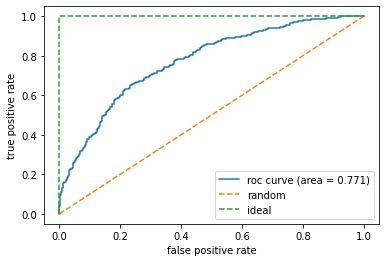

In [37]:
from sklearn.metrics import roc_curve, auc

Y_score = predict
fpr, tpr, thresholds = roc_curve(y_true=test_y, y_score=Y_score)

plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [41]:
raw_importances = cvbooster.feature_importance(importance_type='gain')
feature_name = cvbooster.boosters[0].feature_name()
importance_df = pd.DataFrame(data=raw_importances, columns=feature_name)

In [44]:
importance_df

,aa_tfidf,aaa_tfidf,aaan_tfidf,aarp_tfidf,abatements_tfidf,abbas_tfidf,abbot_tfidf,abbott_tfidf,abc_tfidf,abdulmutallab_tfidf,abele_tfidf,abercrombie_tfidf,ability_tfidf,able_tfidf,aboard_tfidf,abortion_tfidf,abortions_tfidf,about_tfidf,above_tfidf,abramoff_tfidf,abrams_tfidf,abroad_tfidf,absentee_tfidf,absolutely_tfidf,abstinence_tfidf,abuse_tfidf,aca_tfidf,academic_tfidf,academy_tfidf,accenture_tfidf,accept_tfidf,accepted_tfidf,accepting_tfidf,access_tfidf,accident_tfidf,accidents_tfidf,accomplishments_tfidf,according_tfidf,account_tfidf,accountability_tfidf,...,years_tfidf,yemen_tfidf,yes_tfidf,yet_tfidf,yoho_tfidf,york_tfidf,yost_tfidf,you_tfidf,yougov_tfidf,young_tfidf,younger_tfidf,your_tfidf,yourgules_tfidf,youth_tfidf,youtube_tfidf,yovanovitch_tfidf,yucca_tfidf,yuma_tfidf,zaccaria_tfidf,zakaria_tfidf,zandi_tfidf,zant_tfidf,zapata_tfidf,zazi_tfidf,zeifman_tfidf,zeldin_tfidf,zenzinger_tfidf,zerban_tfidf,zero_tfidf,zielinski_tfidf,zika_tfidf,zimmerman_tfidf,zinn_tfidf,zip_tfidf,zombie_tfidf,zone_tfidf,zones_tfidf,zoom_tfidf,zpass_tfidf,zuckerberg_tfidf
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,52.770506,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,15.535341,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,249.770936,0.0,0.0,...,97.407035,0.0,0.000000,0.000000,0.0,19.445082,0.0,39.897978,0.0,16.363050,0.000000,373.310982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,15.918181,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,17.711449,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,791.774818,0.0,0.0,...,233.275761,0.0,34.899141,0.000000,0.0,0.000000,0.0,15.218496,0.0,0.000000,0.000000,186.678825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.55431,0.0,0.0,0.0,0.000000,34.918245,0.0,0.0,0.0,0.0,15.593586,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,266.712395,0.0,0.0,...,0.000000,0.0,0.000000,45.376863,0.0,0.000000,0.0,20.360416,0.0,0.000000,0.000000,329.649572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,49.090042,32.242914,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,547.679830,0.0,0.0,...,64.372952,0.0,0.000000,30.333982,0.0,0.000000,0.0,19.546110,0.0,35.783869,36.419073,378.586980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,48.982402,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,16.825161,0.0,0.0,0.0,299.387318,0.0,0.0,...,80.246029,0.0,33.780085,0.000000,0.0,0.000000,0.0,22.944321,0.0,0.000000,0.000000,580.441499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


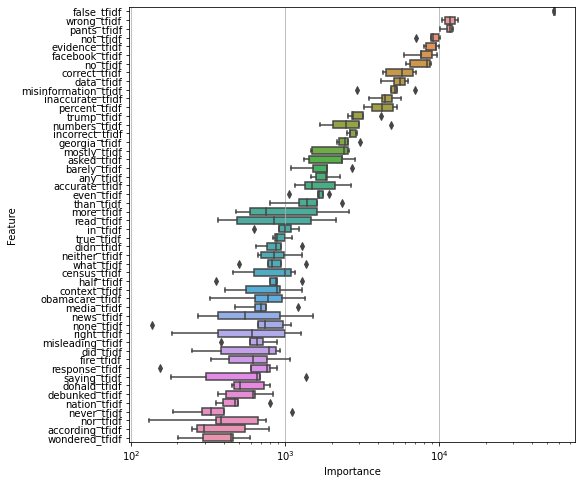

In [43]:
# 平均値でソートする
sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
sorted_importance_df = importance_df.loc[:, sorted_indices]

# 上位をプロットする
PLOT_TOP_N = 50
plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
_, ax = plt.subplots(figsize=(8, 8))
ax.grid()
ax.set_xscale('log')
ax.set_ylabel('Feature')
ax.set_xlabel('Importance')
sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
plt.show()